In [1]:
import sys, os
%load_ext autoreload
%autoreload 2
import torch
import torchvision
import torch.nn.functional as F
import torch.multiprocessing as mp
import torch.distributions as distrib
import torch.nn as nn
import torch.utils.data as td
from torch.utils.data import Dataset, DataLoader, TensorDataset
import gym
import numpy as np
%matplotlib notebook
#%matplotlib tk
import random
import matplotlib.pyplot as plt
import foundation as fd
import foundation.util as util
import foundation.train as train
from foundation import nets
#from foundation.envs.MNIST_envs import MNIST_Walker
import time

In [14]:
parser = train.setup_unsup_options()
args = parser.parse_args(['--config', 'config/unsup-mnist.yaml', '--dataset', 'hf-seq', '--data', 
                         # '/home/fleeb/workspace/pose_nets/se3nets-pytorch/data/reacher-mass1/',
                         '/home/fleeb/workspace/pose_nets/se3nets-pytorch/data/catcher-mass1/',
                         ])
args.use_val = False

In [15]:
traindata, testdata = train.load_data(args=args)
len(traindata), len(testdata)

Found 12 samples in /home/fleeb/workspace/pose_nets/se3nets-pytorch/data/catcher-mass1/ using 12


(261792, 29088)

In [21]:
loader = DataLoader(traindata, batch_size=16, num_workers=4)
len(loader)

16362

In [22]:
itr = iter(loader)

In [27]:
sample = next(itr)
x = sample[0]

In [28]:
x.shape

torch.Size([16, 120, 180, 3])

<IPython.core.display.Javascript object>


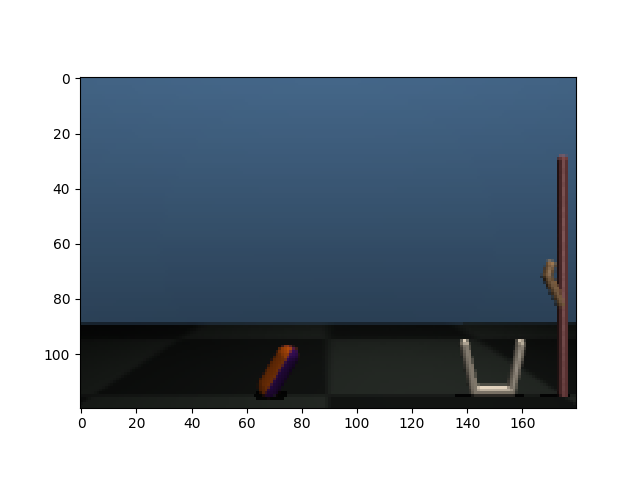

In [31]:
plt.figure()
plt.imshow(x[2].numpy())

In [ ]:
parser = train.setup_unsup_options()
args = parser.parse_args(['--config', 'config/unsup-mnist.yaml', '--name', 'test-mnist', '--model-type', 'var'])

now = time.strftime("%y-%m-%d-%H%M%S")
if args.logdate:
    args.name += '_' + now
args.save_dir = os.path.join(args.saveroot, args.name)
# args.save_dir = os.path.join(args.save_root, args.name)
print('Save dir: {}'.format(args.save_dir))
if args.tblog or args.txtlog:
    util.create_dir(args.save_dir)
    print('Logging in {}'.format(args.save_dir))

logger = util.Logger(args.save_dir, tensorboard=args.tblog, txt=args.txtlog)

if args.no_cuda or not torch.cuda.is_available():
    args.device = 'cpu'
print('Using {}'.format(args.device))

# Set seed
torch.manual_seed(args.seed)
np.random.seed(args.seed)
try:
    torch.cuda.manual_seed(args.seed)
except:
    pass


In [3]:
datasets = train.load_data(args=args)
shuffles = [True, False, False]

loaders = [DataLoader(d, batch_size=args.batch_size, num_workers=args.num_workers) for d, s in zip(datasets, shuffles)]

trainloader, testloader = loaders[0], loaders[-1]
valloader = None if len(loaders) == 2 else loaders[1]

print('traindata len={}, trainloader len={}'.format(len(datasets[0]), len(trainloader)))
if valloader is not None:
    print('valdata len={}, valloader len={}'.format(len(datasets[1]), len(valloader)))
print('testdata len={}, testloader len={}'.format(len(datasets[-1]), len(testloader)))
print('Batch size: {} samples'.format(args.batch_size))

traindata len=45428, trainloader len=355
valdata len=14572, valloader len=114
testdata len=10000, testloader len=79
Batch size: 128 samples


In [4]:
model = train.load_unsup_model(args=args)

print(model)

print('Model has {} parameters'.format(util.count_parameters(model)))

optimizer = nets.get_optimizer(args.optim_type, model.parameters(), lr=args.lr,
                               momentum=args.momentum, weight_decay=args.weight_decay)

model.to(args.device)
#optimizer.to(args.device)

assert not args.resume, 'resuming not supported yet'

scheduler = None
if args.decay_epochs > 0 and args.decay_factor > 0:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=args.decay_epochs,
                                                gamma=args.decay_factor)

if args.no_test:
    print('Will not run test data after training')

args.total_samples = {'train': 0, 'val': 0, 'test': 0}
best_val_loss, best_epoch = float('inf'), 0

Variational_Autoencoder(
  (criterion): BCELoss()
  (enc): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): PReLU(num_parameters=1)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=True)
      (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): PReLU(num_parameters=1)
      (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=True)
      (10): PReLU(num_parameters=1)
    )
    (fc): Sequential(
      (0): Linear(in_features=128, out_features=32, bias=True)
      (1): PReLU(num_parameters=1)
      (2)

In [7]:
epoch = args.start_epoch

In [8]:
if scheduler is not None:
    # Adjust learning rate
    scheduler.step()

train_stats = util.StatsMeter('lr')
train_stats.update('lr', optimizer.param_groups[0]['lr'])

# Train for one epoch
train_stats = train.run_unsup_epoch(loader=trainloader, model=model, logger=logger, args=args,
                    optim=optimizer, unique_tests=args.unique_tests, print_freq=args.print_freq,
                    mode='train', epoch=epoch, stats=train_stats)

C:\Users\anwan\Anaconda3\lib\site-packages\torch\nn\_reduction.py:16: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")
C:\Users\anwan\OneDrive - UW\Khan\AIResearch\foundation\foundation\util\stats.py:284: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.val = torch.tensor(val)
C:\Users\anwan\OneDrive - UW\Khan\AIResearch\foundation\foundation\util\stats.py:291: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.max = torch.tensor(val) if self.max is None else np.maximum(self.max, val)
C:\Users\anwan\OneDrive - UW\Khan\AIResearch\foundation\fou

torch.FloatTensor torch.Size([1, 62, 122, 3])
failed
failed
failed
failed


NameError: name 'quit' is not defined

In [9]:
img = np.random.rand(100,100,3)

In [5]:
gen = model.generate(N=4)
gen.shape

torch.Size([4, 1, 28, 28])

In [ ]:
# Evaluate on validation set
if valloader is not None:
    val_stats = train.run_unsup_epoch(loader=valloader, model=model, logger=logger, args=args,
                        optim=None, unique_tests=args.unique_tests, print_freq=args.print_freq,
                        mode='val', epoch=epoch)
else:
    val_stats = None

In [ ]:
# Find best loss
val_loss = val_stats['loss'] if val_stats is not None else train_stats['loss']  # all models have a flow-vel error - only from predicted/computed delta
is_best = (val_loss.avg < best_val_loss)
prev_best_loss = best_val_loss
prev_best_epoch = best_epoch
if is_best:
    best_val_loss = val_loss.avg
    best_epoch = epoch + 1
    print('==== Epoch: {}, Improved on previous best loss ({:.5f}) from epoch {}. Current: {:.5f} ===='.format(
        epoch + 1, prev_best_loss, prev_best_epoch, val_loss.avg))
else:
    print('==== Epoch: {}, Did not improve on best loss ({:.5f}) from epoch {}. Current: {:.5f} ===='.format(
        epoch + 1, prev_best_loss, prev_best_epoch, val_loss.avg))

model.to('cpu')
#optimizer.to('cpu')

path = train.save_checkpoint({
    'epoch': epoch,
    'args': args,

    'best_loss': best_val_loss,
    'best_epoch': best_epoch,

    'train_stats': train_stats,
    'val_stats': val_stats,

    # 'traindata': datasets[0],
    # 'valdata': datasets[1] if len(datasets)>2 else None,
    # 'testdata': datasets[-1],

    'model_state': model.state_dict(),
    'optim_state': optimizer.state_dict(),
}, save_dir=args.save_dir, is_best=is_best, epoch=epoch+1)

model.to(args.device)
#optimizer.to(args.device)

if path is not None:
    print('--- checkpoint saved: {} ---'.format(path))

print()

epoch += 1

In [ ]:
if args.no_test:
    print('Training complete - and no test')
    return 0

assert False, 'testing not ready yet'

# Load best model for testing (not latest one)
print("=> loading best model from '{}'".format(args.save_dir + "/model_best.pth.tar"))
checkpoint = torch.load(args.save_dir + "/model_best.pth.tar")
num_train_iter = checkpoint['train_iter']
model.load_state_dict(checkpoint['model_state_dict'])
print("=> loaded best checkpoint (epoch {}, train iter {})".format(checkpoint['epoch'], num_train_iter))
best_epoch = checkpoint['best_epoch']
print('==== Best validation loss: {} was from epoch: {} ===='.format(checkpoint['best_loss'],
                                                                     best_epoch))

# Do final testing (if not asked to evaluate)
# (don't create the data loader unless needed, creates 4 extra threads)
print('==== Evaluating trained network on test data ====')
test_stats = iterate(testloader, model, tblogger, -1, mode='test', criterion=criterion, epoch=args.epochs)
print('==== Best validation loss: {} was from epoch: {} ===='.format(best_val_loss,
                                                                     best_epoch))

# Save final test error
save_checkpoint({
    'args': args,
    'test_stats': test_stats
}, False, savedir=args.save_dir, filename='test_stats.pth.tar')

# Close log file
logfile.close()

In [3]:
args = util.NS()

args.num_workers = 4

args.batch_size = 128
args.latent_dim = 2

args.rec_wt = 1.
args.var_wt = 1.

args.channels = [16, 32, 32]
args.kernels = [5, 3, 3]
args.factors = [2, 3, 3]
args.downsampling, args.upsampling = 'max', 'deconv'
args.nonlin = 'prelu'
args.enc_fc = [16]
args.dec_fc = args.enc_fc

args.loss_type = 'mse'

args.epochs = 25
args.decay_factor = 0.1
args.decay_epochs = 12

args.optim_type = 'rmsprop'
args.lr = 1e-3
args.l2 = 1e-4

In [4]:
traindata = torchvision.datasets.MNIST('data/mnist/', train=True, download=True, transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.MNIST('data/mnist/', train=False, download=True, transform=torchvision.transforms.ToTensor())

trainloader = DataLoader(traindata, batch_size=64, shuffle=True)
testloader = DataLoader(testdata, batch_size=128, shuffle=False)

Processing...
Done!


In [20]:
shape = 1, 28, 28
model = nets.AutoEncoder(shape, latent_dim=2, channels=[16, 32, 32], kernels=[5,3,3], factors=[2, 3, 3], up='deconv', down='max',
                         enc_fc=[16], dec_fc=[16], nonlin='prelu', recon_nonlin='sigmoid', batch_norm=False)
epoch = 0
optim = nets.get_optimizer('rmsprop', model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss() #nn.CrossEntropyLoss()
model.cuda()
model

AutoEncoder(
  (enc): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (2): PReLU(num_parameters=1)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=True)
      (5): PReLU(num_parameters=1)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=True)
      (8): PReLU(num_parameters=1)
    )
    (fc): Sequential(
      (0): Linear(in_features=128, out_features=16, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=16, out_features=2, bias=True)
    )
  )
  (dec): Decoder(
    (deconv): Sequential(
      (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), output_padding=(1, 1))
     

In [120]:



def run_parallel_epoch(pid, model, loader, mode='test', optim=None, criterion=None, epoch=None):
    if epoch is None:
        epoch = pid
        
    torch.manual_seed(epoch)
        
    return run_epoch(model, loader, mode, optim, criterion, epoch)

In [122]:
for i in range(10):
    out = run_epoch(model, trainloader, 'train', optim, criterion, pfreq=None)
    print('Ep {}: {:.4f}'.format(i+1, out['loss'].avg))

Ep 1: 0.0026
Ep 2: 0.0022
Ep 3: 0.0019
Ep 4: 0.0019
Ep 5: 0.0017
Ep 6: 0.0014
Ep 7: 0.0015
Ep 8: 0.0015
Ep 9: 0.0013
Ep 10: 0.0012


In [123]:
#pool = mp.Pool(num_workers)

In [124]:
# jobs = [(model, trainloader, 'train', optim, criterion, i) for i in range(epoch, epoch + 10)]
# results = pool.starmap(run_epoch, jobs)
# epoch += len(jobs)

In [125]:
#x = torch.rand(10, D)
#y = model(x)
#torch.cat([x,y], -1)

In [126]:
r = 15
X = torch.linspace(-r, r, 1000)#.view(-1, 1)
Y = f(X)
P = model(X.view(-1, 1)).view(-1).detach()
X, Y, P = X.numpy(), Y.numpy(), P.numpy()
X.shape, Y.shape, P.shape

((1000,), (1000,), (1000,))

<IPython.core.display.Javascript object>


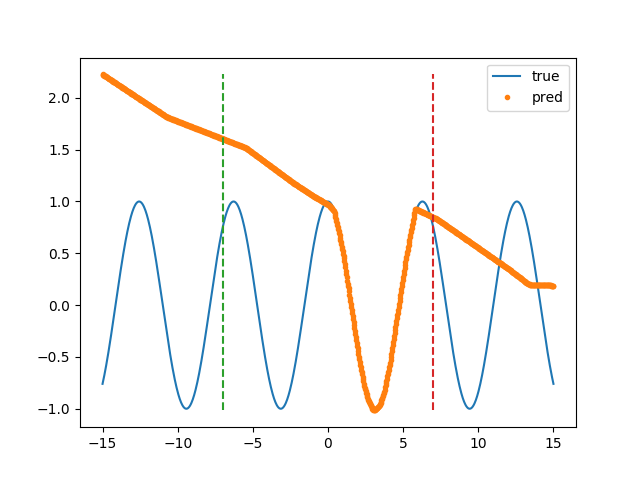

In [127]:
plt.figure()
plt.plot(X, Y, label='true')
plt.plot(X, P, ls='', marker='.', label='pred')
plt.plot([-t,-t], [min(Y.min(),P.min()),max(Y.max(),P.max())], ls='--')
plt.plot([t,t], [min(Y.min(),P.min()),max(Y.max(),P.max())], ls='--')
plt.legend()

In [14]:
#run_epoch(model, trainloader, 'true', optim, criterion)

In [19]:
#run_parallel_epoch(0, model, trainloader, 'true', optim, criterion)

In [17]:
workers = mp.spawn(run_parallel_epoch, args=(model, trainloader, 'train', optim, criterion), nprocs=num_workers, daemon=True)

Exception: process 1 terminated with exit code 1

In [ ]:
mp.

In [3]:
#env = MNIST_Walker(batch_size=5, sparse_reward=False)

In [4]:
state = env.reset()
state.size(), env.lbl_state

(torch.Size([5, 1, 28, 28]), tensor([ 3,  9,  3,  6,  1]))

In [20]:
state, reward, _, _ = env.step([ 0,0,1,2,2])
env.lbl_state, reward

(tensor([ 0,  0,  3,  9,  9]), tensor([ 0,  0, -3, -9, -9]))

<IPython.core.display.Javascript object>


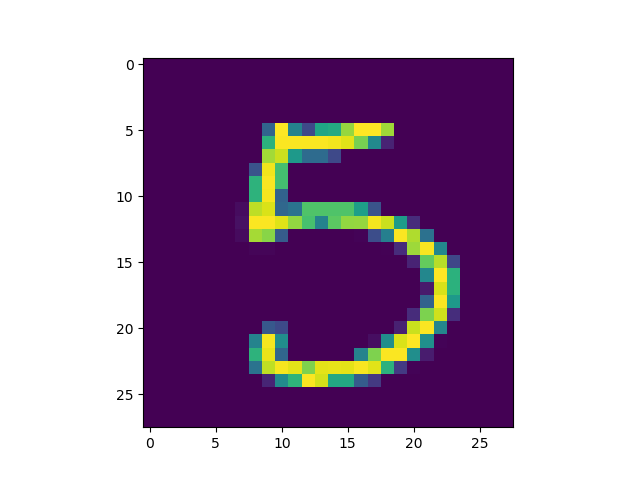

In [8]:
plt.figure()
plt.imshow(state[0,0].numpy())

In [20]:
for imgs, lbls in trainloader:
    break
imgs.size(), lbls.size()

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

In [51]:
class Encoder(nn.Module):
    def __init__(self, in_shape=(1,28,28), latent_dim=2, meta_dim=0, nonlin='prelu'):
        super(Encoder, self).__init__()
        
        assert latent_dim + meta_dim > 0
        
        self.conv, self.conv_dout = fd.nets.make_conv_net(in_shape=in_shape, 
                                                          nonlin=nonlin, output_nonlin=nonlin,
                                                          channels=[4,8,16], 
                                                          kernels=[7,5,3], 
                                                          pooling=[True]*3,)
        self.fc_din = np.prod(self.conv_dout)
        
        self.fc = fd.nets.make_MLP(input_dim=self.fc_din+meta_dim, 
                                   hidden_dims=[32], 
                                   output_dim=latent_dim,
                                   nonlinearity=nonlin,
                                  )
        
    def forward(self, x, m=None):
        
        y = self.conv(x).view(-1, self.fc_din)
        
        if m is not None:
            m = m.view(-1, self.meta_dim)
            y = torch.cat([y, m],-1)
        
        return self.fc(y)

#encoder = Encoder()
#print(encoder)
model = Encoder(latent_dim=10)
print(model)

Encoder(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): PReLU(num_parameters=1)
    (4): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): PReLU(num_parameters=1)
    (8): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): PReLU(num_parameters=1)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=32, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Line

In [ ]:
trainloader = DataLoader(traindata, batch_size=1, shuffle=False)

<IPython.core.display.Javascript object>


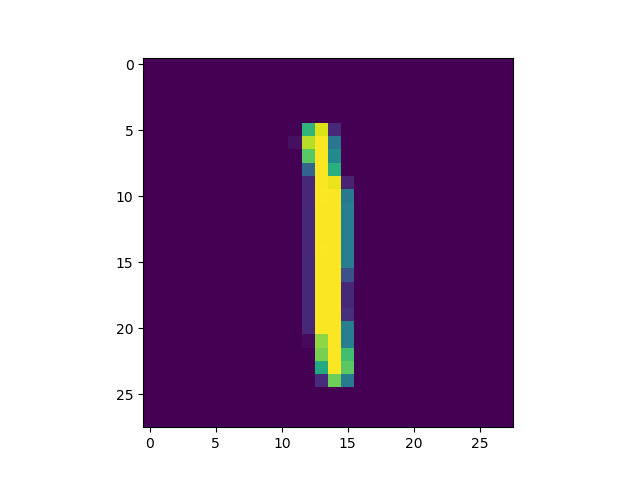

In [32]:
plt.figure()
plt.imshow(imgs[14].numpy())